# Basis functions
In this notebook we bring in the idea of basis functions, and see how piecewise regression can be seen as linear modelling.

The focus of this notebook is to explore the concepts... the code is not meant to be a neat generalized solution to running piecewise/basis regression models at this point.

In [1]:
using Distributions, Plots, StatsBase, StatsPlots, Turing

<div class="alert alert-block alert-warning">
<b>FYI:</b> When we run Bayesian inference below, we will attempt to run mulitple chains in parallel. Below we check how many threads we have access to.
</div>

In [2]:
n_chains = Threads.nthreads()
print(n_chains)

8

## Create some data

In [3]:
n_observations = 100

f(x) = 0 -2(x/30) -1(x/30)^2 + 4(x/30)^3;
x = sort(rand(Uniform(-30, 30), n_observations))
y = f.(x) + randn(length(x))*0.25

100-element Array{Float64,1}:
 -2.778039690086546
 -2.1447219319107607
 -2.577687904100509
 -1.9616237515572439
 -1.580500882426393
 -1.1191877536902408
 -1.255656635957354
 -1.5696592797928948
 -1.0009605068681466
 -1.2975280678001404
 -0.6527211438671339
 -0.42743233754027604
 -0.5909743631639308
  ⋮
 -0.4453276665806375
 -0.5627946667398604
 -0.38416659623388943
 -0.5897091225112091
  0.02159384348729204
 -0.45343016768353733
  0.3014274808763874
  0.24698484709435328
  0.017041723807646847
  0.7576362058181626
  0.8315147993213806
  1.2350968941371234

Create some knots. Just like in previous notebooks, we are treating these as fixed (as opposed to free) parameters in the model. They are defined by uniformly spacing them along the ordered $x$ values.

In [4]:
k = percentile(x, [20, 40, 60, 80])
print(k)

[-18.71697201380853, -9.249643364320155, 2.483007055506742, 12.743149753579868]

Visualise the data and the knots.

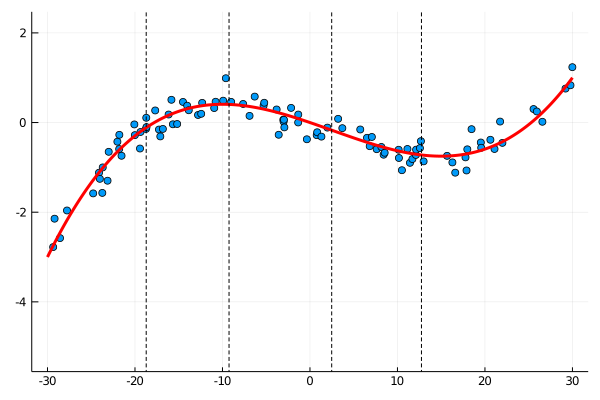

In [5]:
function plot_data(x, y)
    scatter(x, y, label="data")
    xi = [-30:0.01:30;]
    plot!(xi, f.(xi), label="true", lw=3, color=:red)
    plot!(legend=false)
end

function plot_knots(k)
    vline!(k, color=:black, linestyle=:dash)
    plot!(ylim=(minimum(y)*2, maximum(y)*2))
end

plot_data(x, y)
plot_knots(k)

## Basis functions for piecewise constant regression

In [6]:
function make_constant_bases(k)
    f0(x) = 1
    f1(x) = x≤k[1] ? 1 : 0
    f2(x) = k[1]<x≤k[2] ? 1 : 0
    f3(x) = k[2]<x≤k[3] ? 1 : 0
    f4(x) = k[3]<x≤k[4] ? 1 : 0
    f5(x) = x>k[4] ? 1 : 0
    return [f0, f1, f2, f3, f4, f5]
end

constant_basis_functions = make_constant_bases(k);

We can visualise what these basis functions look like.

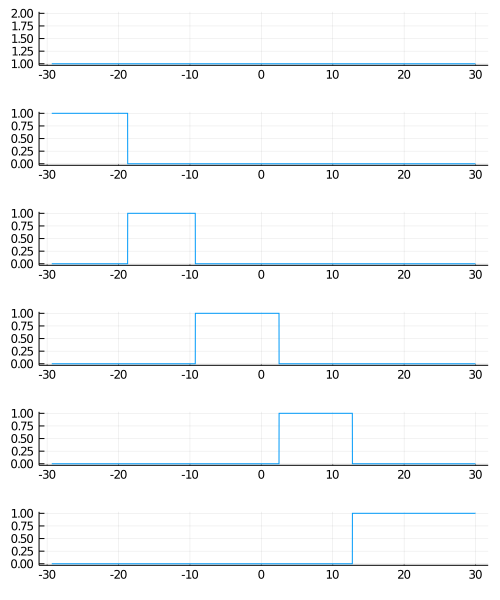

In [8]:
function plot_basis_functions(basis_functions, xi)
    n_basis_functions = length(basis_functions)
    xi = LinRange(minimum(x), maximum(x), 5000)
    plot(layout=(n_basis_functions,1), size=(500, 600))
    for i in 1:n_basis_functions
        plot!(xi, basis_functions[i].(xi), subplot=i, legend=false)
    end
    plot!()
end

xi = LinRange(-35, 35, 500)

plot_basis_functions(constant_basis_functions, xi)

Now we can create a design matrix $X$. Each row will be an observation. Each column will correspond to a basis vector

In [9]:
function design_matrix(x, basis_functions)
    n_observations = length(x)
    n_basis_funcs = length(basis_functions)
    X = zeros(Float64, (n_observations, n_basis_funcs))
    
    for row in 1:n_observations
        for basis in 1:n_basis_funcs
            X[row, basis] = basis_functions[basis](x[row])
        end
    end
    return X
end

design_matrix (generic function with 1 method)

In [10]:
X = design_matrix(x, constant_basis_functions)

100×6 Array{Float64,2}:
 1.0  1.0  0.0  0.0  0.0  0.0
 1.0  1.0  0.0  0.0  0.0  0.0
 1.0  1.0  0.0  0.0  0.0  0.0
 1.0  1.0  0.0  0.0  0.0  0.0
 1.0  1.0  0.0  0.0  0.0  0.0
 1.0  1.0  0.0  0.0  0.0  0.0
 1.0  1.0  0.0  0.0  0.0  0.0
 1.0  1.0  0.0  0.0  0.0  0.0
 1.0  1.0  0.0  0.0  0.0  0.0
 1.0  1.0  0.0  0.0  0.0  0.0
 1.0  1.0  0.0  0.0  0.0  0.0
 1.0  1.0  0.0  0.0  0.0  0.0
 1.0  1.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮
 1.0  0.0  0.0  0.0  0.0  1.0
 1.0  0.0  0.0  0.0  0.0  1.0
 1.0  0.0  0.0  0.0  0.0  1.0
 1.0  0.0  0.0  0.0  0.0  1.0
 1.0  0.0  0.0  0.0  0.0  1.0
 1.0  0.0  0.0  0.0  0.0  1.0
 1.0  0.0  0.0  0.0  0.0  1.0
 1.0  0.0  0.0  0.0  0.0  1.0
 1.0  0.0  0.0  0.0  0.0  1.0
 1.0  0.0  0.0  0.0  0.0  1.0
 1.0  0.0  0.0  0.0  0.0  1.0
 1.0  0.0  0.0  0.0  0.0  1.0

Now we can just calculate the estimated $y$ values by $y^{est} = X \cdot \beta$. For the moment we will use random set of parameters.

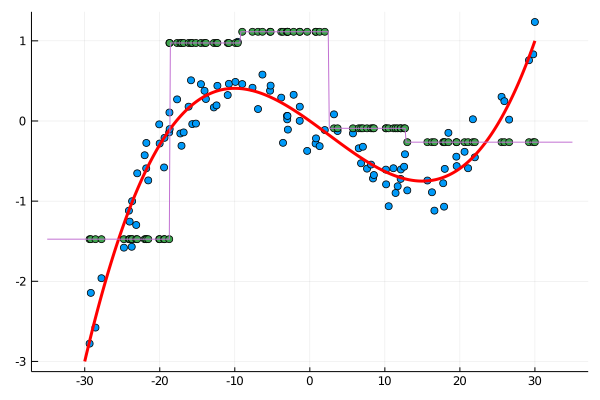

In [11]:
plot_data(x, y)

# random weight vector
β = rand(Normal(0, 1), length(constant_basis_functions))
y_est = X * β
scatter!(x, y_est, legend=false)

# interpolation
plot!(xi, design_matrix(xi, constant_basis_functions) * β)

## Bayesian parameter estimation

So now we have the piecewise constant regression model formulated as a linear model. We've just used a set of basis functions in order to generate a design matrix. So we should be able to proceed and esimate the parameters of our linear model.

In [12]:
@model function linear_model(X, y)
    n_obs, n_bases = size(X)
    β ~ filldist(Normal(0, 1), n_bases)
    σ ~ truncated(Normal(0, 2), 0, Inf)
    μ = X * β
    @. y ~ Normal(μ, σ)
end;

In [13]:
chains = sample(linear_model(X, y), NUTS(), MCMCThreads(), 1000, n_chains)

┌ Info: Found initial step size
│   ϵ = 0.025
└ @ Turing.Inference /Users/benjamv/.julia/packages/Turing/O1Pn0/src/inference/hmc.jl:195
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /Users/benjamv/.julia/packages/Turing/O1Pn0/src/inference/hmc.jl:195
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /Users/benjamv/.julia/packages/Turing/O1Pn0/src/inference/hmc.jl:195
┌ Info: Found initial step size
│   ϵ = 0.025
└ @ Turing.Inference /Users/benjamv/.julia/packages/Turing/O1Pn0/src/inference/hmc.jl:195
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /Users/benjamv/.julia/packages/Turing/O1Pn0/src/inference/hmc.jl:195
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /Users/benjamv/.julia/packages/Turing/O1Pn0/src/inference/hmc.jl:195
┌ Info: Found initial step size
│   ϵ = 0.025
└ @ Turing.Inference /Users/benjamv/.julia/packages/Turing/O1Pn0/src/inference/hmc.jl:195
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turin

Chains MCMC chain (1000×19×8 Array{Float64,3}):

Iterations        = 1:1000
Thinning interval = 1
Chains            = 1, 2, 3, 4, 5, 6, 7, 8
Samples per chain = 1000
parameters        = β[1], β[2], β[3], β[4], β[5], β[6], σ
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat 
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64 

        β[1]   -0.2386    0.4054     0.0045    0.0106   1392.5400    1.0046
        β[2]   -0.8111    0.4142     0.0046    0.0105   1478.8432    1.0044
        β[3]    0.4542    0.4166     0.0047    0.0106   1445.2853    1.0045
        β[4]    0.3192    0.4158     0.0046    0.0105   1452.8701    1.0045
        β[5]   -0.3089    0.4160     0.0047    0.0106   1470.9577    1.0044
        β[6]   -0

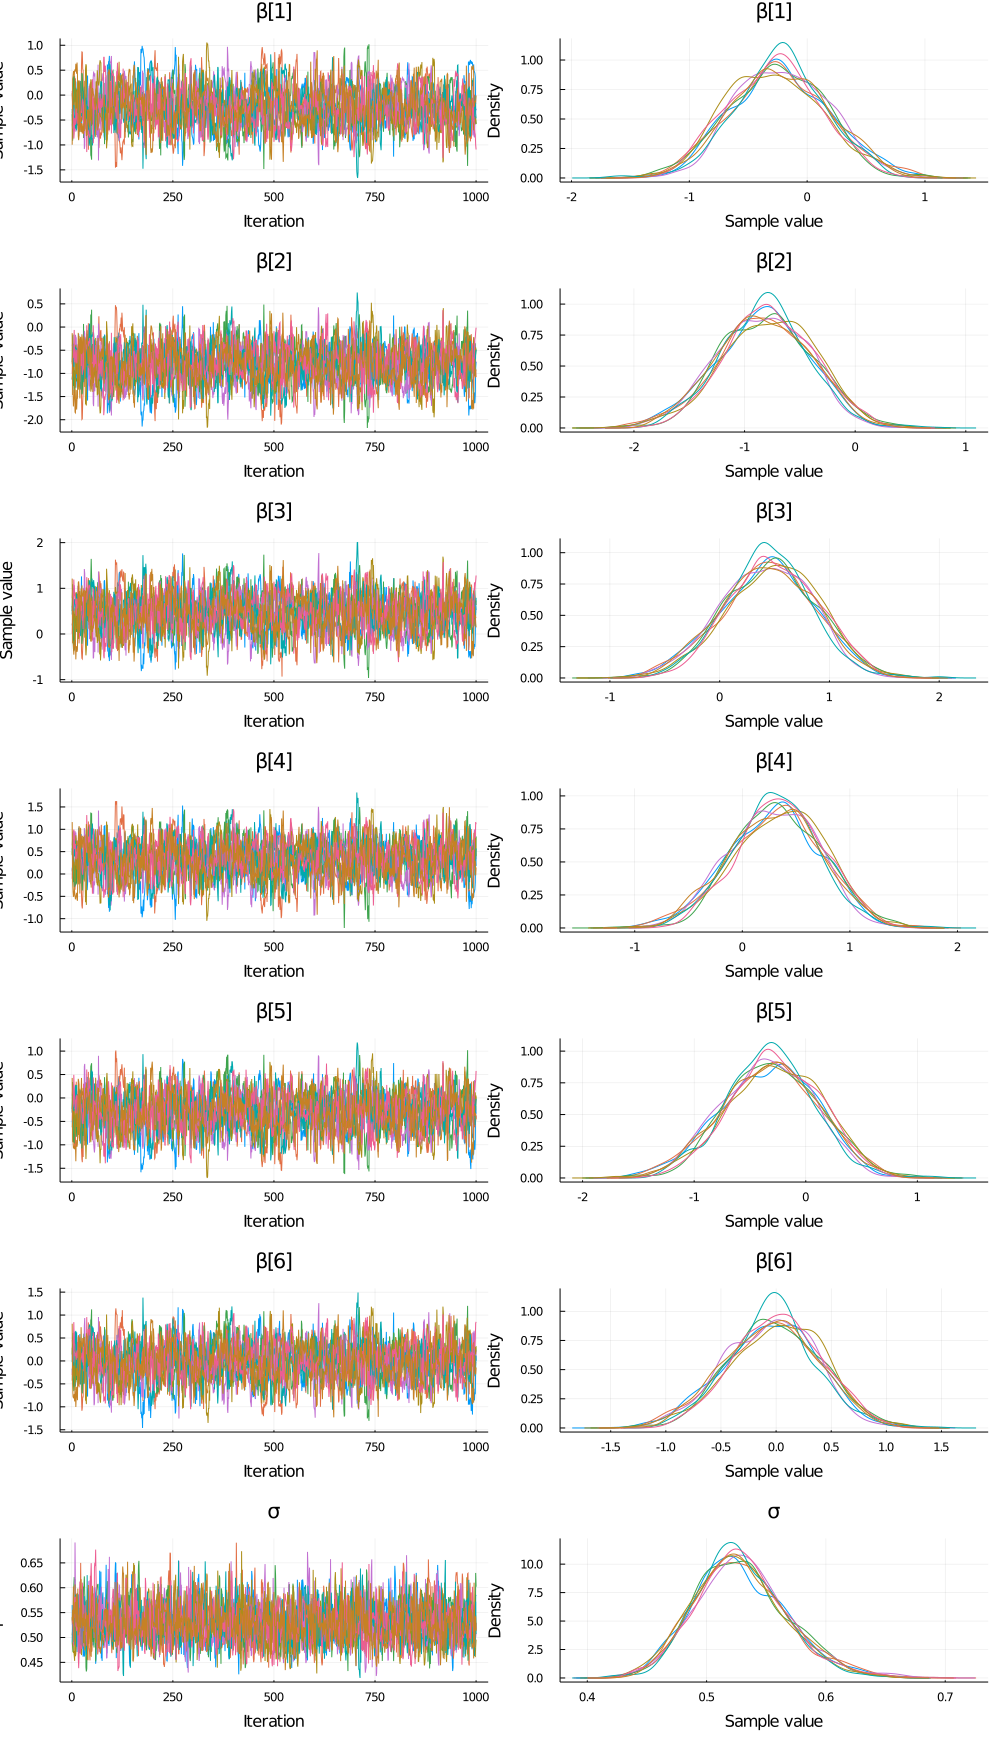

In [14]:
plot(chains)

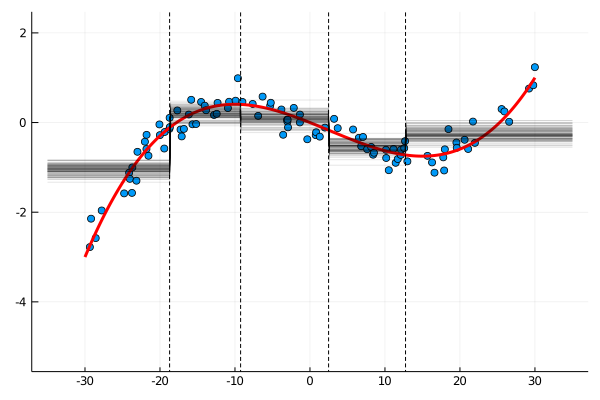

In [17]:
β1 = vec(chains["β[1]"])
β2 = vec(chains["β[2]"])
β3 = vec(chains["β[3]"])
β4 = vec(chains["β[4]"])
β5 = vec(chains["β[5]"])
β6 = vec(chains["β[6]"])

# plot data ---------------------------------------------------------
plot_data(x, y)
plot_knots(k)

# plot samples from posterior ---------------------------------------
subsamples = 100
ind = rand(1:length(β1), subsamples)
for i in ind
    β = vec([β1[i] β2[i] β3[i] β4[i] β5[i] β6[i]])
    yi = design_matrix(xi, constant_basis_functions) * β  # linear model
    plot!(xi, yi, color=:black, alpha=0.1)
end
plot!()

## Piecewise linear regression
Now let's do the same for piecewise linear regression

In [18]:
function make_linear_bases(k)
    f0(x) = 1
    f1(x) = x
    f2(x) = T(x, k[1])
    f3(x) = T(x, k[2])
    f4(x) = T(x, k[3])
    f5(x) = T(x, k[4])
    return [f0, f1, f2, f3, f4, f5]
end

T(x, k) = (x-k)*(x≥k);

linear_basis_functions = make_linear_bases(k);

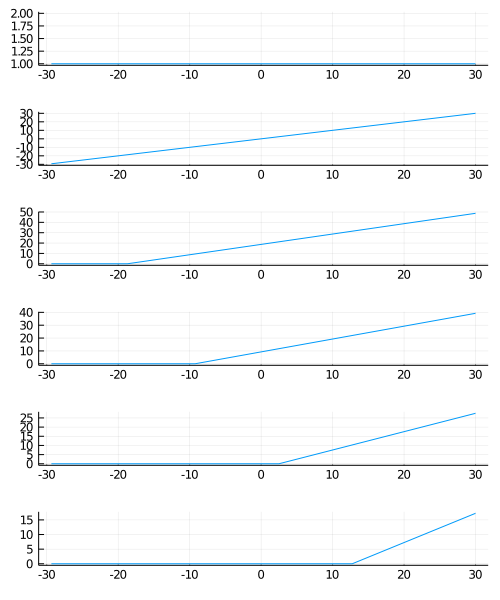

In [19]:
plot_basis_functions(linear_basis_functions, xi)

In [20]:
X = design_matrix(x, linear_basis_functions)

100×6 Array{Float64,2}:
 1.0  -29.3502  -0.0     -0.0     -0.0     -0.0
 1.0  -29.1901  -0.0     -0.0     -0.0     -0.0
 1.0  -28.5698  -0.0     -0.0     -0.0     -0.0
 1.0  -27.77    -0.0     -0.0     -0.0     -0.0
 1.0  -24.777   -0.0     -0.0     -0.0     -0.0
 1.0  -24.1126  -0.0     -0.0     -0.0     -0.0
 1.0  -24.0151  -0.0     -0.0     -0.0     -0.0
 1.0  -23.735   -0.0     -0.0     -0.0     -0.0
 1.0  -23.6861  -0.0     -0.0     -0.0     -0.0
 1.0  -23.1372  -0.0     -0.0     -0.0     -0.0
 1.0  -23.0031  -0.0     -0.0     -0.0     -0.0
 1.0  -22.0108  -0.0     -0.0     -0.0     -0.0
 1.0  -21.8046  -0.0     -0.0     -0.0     -0.0
 ⋮                                          ⋮
 1.0   19.528   38.245   28.7777  17.045    6.7849
 1.0   19.5747  38.2917  28.8244  17.0917   6.83157
 1.0   20.6221  39.3391  29.8718  18.1391   7.879
 1.0   21.0918  39.8088  30.3415  18.6088   8.34869
 1.0   21.732   40.449   30.9816  19.249    8.98884
 1.0   21.9935  40.7105  31.2432  19.5105   9.250

In [21]:
chains = sample(linear_model(X, y), NUTS(), MCMCThreads(), 1000, n_chains)

┌ Info: Found initial step size
│   ϵ = 0.00625
└ @ Turing.Inference /Users/benjamv/.julia/packages/Turing/O1Pn0/src/inference/hmc.jl:195
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/benjamv/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, true, false)
└ @ AdvancedHMC /Users/benjamv/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/benjamv/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, true, false)
└ @ AdvancedHMC /Users/benjamv/.julia/packages/AdvancedHMC/MI

Chains MCMC chain (1000×19×8 Array{Float64,3}):

Iterations        = 1:1000
Thinning interval = 1
Chains            = 1, 2, 3, 4, 5, 6, 7, 8
Samples per chain = 1000
parameters        = β[1], β[2], β[3], β[4], β[5], β[6], σ
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat 
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64 

        β[1]    3.8947    0.3093     0.0035    0.0058   2575.9174    1.0009
        β[2]    0.2128    0.0138     0.0002    0.0003   2676.1636    1.0011
        β[3]   -0.1464    0.0229     0.0003    0.0004   2423.9435    1.0009
        β[4]   -0.1289    0.0222     0.0002    0.0004   2944.1565    1.0017
        β[5]   -0.0114    0.0216     0.0002    0.0004   2999.5023    1.0031
        β[6]    0

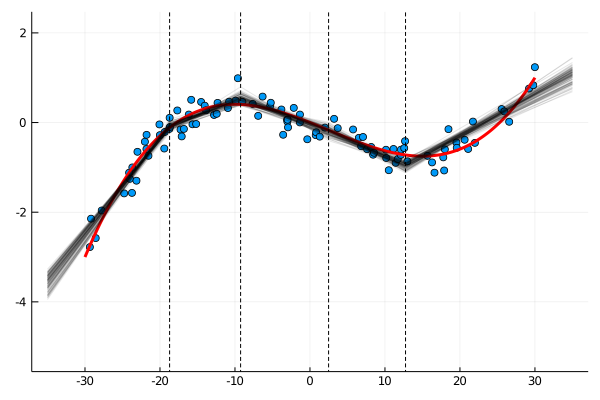

In [23]:
β1 = vec(chains["β[1]"])
β2 = vec(chains["β[2]"])
β3 = vec(chains["β[3]"])
β4 = vec(chains["β[4]"])
β5 = vec(chains["β[5]"])
β6 = vec(chains["β[6]"])

# plot data ---------------------------------------------------------
plot_data(x, y)
plot_knots(k)

# plot samples from posterior ---------------------------------------
subsamples = 100
ind = rand(1:length(β1), subsamples)
for i in ind
    β = vec([β1[i] β2[i] β3[i] β4[i] β5[i] β6[i]])
    yi = design_matrix(xi, linear_basis_functions) * β  # linear model
    plot!(xi, yi, color=:black, alpha=0.1)
end
plot!()